In [1]:
import collections
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, ttest_ind as ttest, ttest_ind_from_stats as ttest_stats
from scipy.optimize import curve_fit

TRIALS = 5

def linear(x, slope, intercept):
    return np.poly1d([slope, intercept])(x)

def percent(total, δtotal, t, δt):
    per = t / total
    unc = np.abs(per) * np.sqrt(np.power(δt / t, 2) + np.power(δtotal / total, 2))
    return (per * 100, unc * 100)

In [2]:
### Unsized times

unsized = [15.22, 15.19, 15.02, 15.08, 15.10]
unsized_mean = np.mean(unsized)
unsized_std = np.std(unsized)

unsized_totals = collections.defaultdict(lambda : (0., 0.))
unsized_percent = collections.defaultdict(lambda : (0., 0.))

# Stats for all timing measurements except solve

files = []
readers = []
for i in range(1, TRIALS + 1):
    file = open(f"/home/jonathan/Documents/coq/MSetList/stats{i}.csv")
    files.append(file)
    readers.append(csv.reader(file))

for rows in zip(*readers):
    name = rows[0][0]
    times = [float(row[1]) for row in rows]
    total_mean, total_std = unsized_totals[name]
    unsized_totals[name] = (total_mean + np.mean(times), total_std + np.std(times))
    
for file in files:
    file.close()

for k in unsized_totals:
    if unsized_totals[k][0] != 0:
        unsized_percent[k] = percent(unsized_mean, unsized_std, unsized_totals[k][0], unsized_totals[k][1])
        
# Stats for solve

solve_times = []
solve_uncs = []

files = []
readers = []
for i in range(1, TRIALS + 1):
    file = open(f"/home/jonathan/Documents/coq/MSetList/solve{i}.csv")
    files.append(file)
    readers.append(csv.reader(file))
    
for rows in zip(*readers):
    times = [float(row[0]) for row in rows]
    solve_times.append(np.mean(times))
    solve_uncs.append(np.std(times))

for file in files:
    file.close()

unsized_totals["solve"] = (sum(solve_times), sum(solve_uncs))
unsized_percent["solve"] = percent(unsized_mean, unsized_std, unsized_totals["solve"][0], unsized_totals["solve"][1])

# Display totals

print(f"Unsized total `coqc` time: \t\t\t{unsized_mean : >2.4f} ± {unsized_std : 1.4f}")
print(f"`infer`, `infer_type`, `check_with_type`: \t{unsized_totals['infer'][0] : 2.4f} ± {unsized_totals['infer'][1] : 1.4f}\t"
      f"{unsized_percent['infer'][0] : >2.2f} ± {unsized_percent['infer'][1] : 2.2f}")
print(f"`solve`: \t\t\t\t\t{unsized_totals['solve'][0] : 2.4f} ± {unsized_totals['solve'][1] : 1.4f}\t"
      f"{unsized_percent['solve'][0] : >2.2f} ± {unsized_percent['solve'][1] : 2.2f}")
print(f"`Constraints`: \t\t\t\t\t{unsized_totals['constraints'][0] : 2.4f} ± {unsized_totals['constraints'][1] : 1.4f}\t"
      f"{unsized_percent['constraints'][0] : 2.2f} ± {unsized_percent['constraints'][1] : 2.2f}")
print(f"`SMap`: \t\t\t\t\t{unsized_totals['smap'][0] : 2.4f} ± {unsized_totals['smap'][1] : 1.4f}\t"
      f"{unsized_percent['smap'][0] : 2.2f} ± {unsized_percent['smap'][1] : 2.2f}")
print(f"`State`: \t\t\t\t\t{unsized_totals['state'][0] : 2.4f} ± {unsized_totals['state'][1] : 1.4f}\t"
      f"{unsized_percent['state'][0] : 2.2f} ± {unsized_percent['state'][1] : 2.2f}")
print(f"`foldmap_annots`: \t\t\t\t{unsized_totals['foldmap_annots'][0] : 2.4f} ± {unsized_totals['foldmap_annots'][1] : 1.4f}\t"
      f"{unsized_percent['foldmap_annots'][0] : >2.2f} ± {unsized_percent['foldmap_annots'][1] : 2.2f}")

Unsized total `coqc` time: 			15.1220 ±  0.0733
`infer`, `infer_type`, `check_with_type`: 	 3.5691 ±  0.0566	23.60 ±  0.39
`solve`: 					 0.0291 ±  0.0023	0.19 ±  0.02
`Constraints`: 					 0.1859 ±  0.0048	 1.23 ±  0.03
`SMap`: 					 0.0109 ±  0.0006	 0.07 ±  0.00
`State`: 					 0.0468 ±  0.0015	 0.31 ±  0.01
`foldmap_annots`: 				 0.1629 ±  0.0036	1.08 ±  0.02


In [3]:
### Sized times

sized = [83.37, 84.01, 83.56, 83.99, 83.37]
sized_mean = np.mean(sized)
sized_std = np.std(sized)

sized_totals = collections.defaultdict(lambda : (0., 0.))
sized_percent = collections.defaultdict(lambda : (0., 0.))

# Stats for all timing measurements except solve, RecCheck

files = []
readers = []
for i in range(1, TRIALS + 1):
    file = open(f"/home/jonathan/Documents/coq/MSetList_sized/stats{i}.csv")
    files.append(file)
    readers.append(csv.reader(file))

for rows in zip(*readers):
    name = rows[0][0]
    times = [float(row[1]) for row in rows]
    total_mean, total_std = sized_totals[name]
    sized_totals[name] = (total_mean + np.mean(times), total_std + np.std(times))
    
for file in files:
    file.close()

for k in sized_totals:
    if sized_totals[k][0] != 0:
        sized_percent[k] = percent(sized_mean, sized_std, sized_totals[k][0], sized_totals[k][1])
        
# Stats for solve

solve_times = []
solve_uncs = []
solve_constraints = []
solve_variables = []

files = []
readers = []
for i in range(1, TRIALS + 1):
    file = open(f"/home/jonathan/Documents/coq/MSetList_sized/solve{i}.csv")
    files.append(file)
    readers.append(csv.reader(file))
    
for rows in zip(*readers):
    times = [float(row[0]) for row in rows]
    solve_times.append(np.mean(times))
    solve_uncs.append(np.std(times))
    solve_constraints.append(int(rows[0][1]))
    solve_variables.append(int(rows[0][2]))

for file in files:
    file.close()

sized_totals["solve"] = (sum(solve_times), sum(solve_uncs))
sized_percent["solve"] = percent(sized_mean, sized_std, sized_totals["solve"][0], sized_totals["solve"][1])

# Stats for RecCheck

reccheck_times = []
reccheck_uncs = []
reccheck_constraints = []
reccheck_variables = []

files = []
readers = []
for i in range(1, TRIALS + 1):
    file = open(f"/home/jonathan/Documents/coq/MSetList_sized/reccheck{i}.csv")
    files.append(file)
    readers.append(csv.reader(file))
    
for rows in zip(*readers):
    times = [float(row[0]) for row in rows]
    reccheck_times.append(np.mean(times))
    reccheck_uncs.append(np.std(times))
    reccheck_constraints.append(int(rows[0][1]))
    reccheck_variables.append(int(rows[0][2]))

for file in files:
    file.close()

sized_totals["reccheck"] = (sum(reccheck_times), sum(reccheck_uncs))
sized_percent["reccheck"] = percent(sized_mean, sized_std, sized_totals["reccheck"][0], sized_totals["reccheck"][1])

# Display totals

print(f"Sized total `coqc` time: \t\t\t{sized_mean : >2.4f} ± {sized_std : 1.4f}")
print(f"`infer`, `infer_type`, `check_with_type`: \t{sized_totals['infer'][0] : 2.4f} ± {sized_totals['infer'][1] : 1.4f}\t"
      f"{sized_percent['infer'][0] : >2.2f} ± {sized_percent['infer'][1] : 2.2f}")
print(f"`solve`: \t\t\t\t\t{sized_totals['solve'][0] : 2.4f} ± {sized_totals['solve'][1] : 1.4f}\t"
      f"{sized_percent['solve'][0] : >2.2f} ± {sized_percent['solve'][1] : 2.2f}")
print(f"`RecCheck`: \t\t\t\t\t{sized_totals['reccheck'][0] : 2.4f} ± {sized_totals['reccheck'][1] : 1.4f}\t"
      f"{sized_percent['reccheck'][0] : >2.2f} ± {sized_percent['reccheck'][1] : 2.2f}")
print(f"`Constraints`: \t\t\t\t\t{sized_totals['constraints'][0] : 2.4f} ± {sized_totals['constraints'][1] : 1.4f}\t"
      f"{sized_percent['constraints'][0] : 2.2f} ± {sized_percent['constraints'][1] : 2.2f}")
print(f"`SMap`: \t\t\t\t\t{sized_totals['smap'][0] : 2.4f} ± {sized_totals['smap'][1] : 1.4f}\t"
      f"{sized_percent['smap'][0] : 2.2f} ± {sized_percent['smap'][1] : 2.2f}")
print(f"`State`: \t\t\t\t\t{sized_totals['state'][0] : 2.4f} ± {sized_totals['state'][1] : 1.4f}\t"
      f"{sized_percent['state'][0] : 2.2f} ± {sized_percent['state'][1] : 2.2f}")
print(f"`foldmap_annots`: \t\t\t\t{sized_totals['foldmap_annots'][0] : 2.4f} ± {sized_totals['foldmap_annots'][1] : 1.4f}\t"
      f"{sized_percent['foldmap_annots'][0] : >2.2f} ± {sized_percent['foldmap_annots'][1] : 2.2f}")

Sized total `coqc` time: 			83.6600 ±  0.2862
`infer`, `infer_type`, `check_with_type`: 	 71.1931 ±  0.4504	85.10 ±  0.61
`solve`: 					 62.3971 ±  0.4135	74.58 ±  0.56
`RecCheck`: 					 2.2033 ±  0.0225	2.63 ±  0.03
`Constraints`: 					 2.8988 ±  0.0276	 3.46 ±  0.04
`SMap`: 					 0.2813 ±  0.0027	 0.34 ±  0.00
`State`: 					 0.1038 ±  0.0018	 0.12 ±  0.00
`foldmap_annots`: 				 0.2655 ±  0.0035	0.32 ±  0.00


In [4]:
### t-statistics for sized vs. unsized

tstat, pvalue = ttest(sized, unsized)
t_infer,       p_infer       = ttest_stats(sized_totals["infer"][0],          sized_totals["infer"][1],          TRIALS, unsized_totals["infer"][0],          unsized_totals["infer"][1],          TRIALS)
t_solve,       p_solve       = ttest_stats(sized_totals["solve"][0],          sized_totals["solve"][1],          TRIALS, unsized_totals["solve"][0],          unsized_totals["solve"][1],          TRIALS)
t_reccheck,    p_reccheck    = ttest_stats(sized_totals["reccheck"][0],       sized_totals["reccheck"][1],       TRIALS, unsized_totals["reccheck"][0],       unsized_totals["reccheck"][1],       TRIALS)
t_constraints, p_constraints = ttest_stats(sized_totals["constraints"][0],    sized_totals["constraints"][1],    TRIALS, unsized_totals["constraints"][0],    unsized_totals["constraints"][1],    TRIALS)
t_smap,        p_smap        = ttest_stats(sized_totals["smap"][0],           sized_totals["smap"][1],           TRIALS, unsized_totals["smap"][0],           unsized_totals["smap"][1],           TRIALS)
t_state,       p_state       = ttest_stats(sized_totals["state"][0],          sized_totals["state"][1],          TRIALS, unsized_totals["state"][0],          unsized_totals["state"][1],          TRIALS)
t_foldmap,     p_foldmap     = ttest_stats(sized_totals["foldmap_annots"][0], sized_totals["foldmap_annots"][1], TRIALS, unsized_totals["foldmap_annots"][0], unsized_totals["foldmap_annots"][1], TRIALS)
print(f"Total:       t = {tstat};\t"         f"p = {pvalue}")
print(f"infer:       t = {t_infer};\t"       f"p = {p_infer}")
print(f"solve:       t = {t_solve};\t"       f"p = {p_solve}")
print(f"RecCheck:    t = {t_reccheck};\t"    f"p = {p_reccheck}")
print(f"Constraints: t = {t_constraints};\t" f"p = {p_constraints}")
print(f"SMap:        t = {t_smap};\t"        f"p = {p_smap}")
print(f"State:       t = {t_state};\t"       f"p = {p_state}")
print(f"foldmap:     t = {t_foldmap};\t"     f"p = {p_foldmap}")

Total:       t = 463.9425985910247;	p = 5.217301186270152e-19
infer:       t = 333.076336122353;	p = 7.391882485785785e-18
solve:       t = 337.2207355751021;	p = 6.6956673120995356e-18
RecCheck:    t = 219.11338914493695;	p = 2.1067169733125296e-16
Constraints: t = 216.5778609372518;	p = 2.3122719481069313e-16
SMap:        t = 215.17264135195373;	p = 2.435855314539892e-16
State:       t = 54.86771439888585;	p = 1.3506217968633767e-11
foldmap:     t = 45.7407117316837;	p = 5.765376611790438e-11


Slope: 1.1406402216672092e-06
Intercept: 0.00013585679748848346
r: 0.697599231455035
Reduced χ²: 9420.472316577881


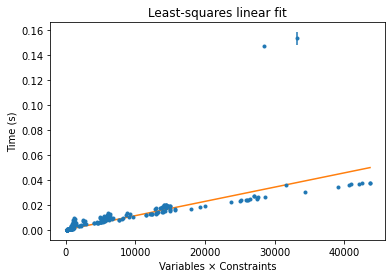

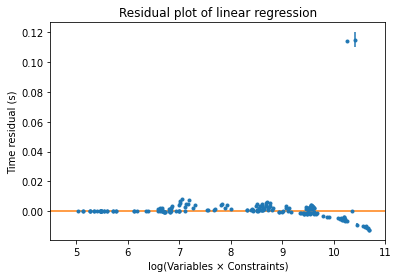

In [5]:
### Plotting `RecCheck` times against |constraints| × |variables|

reccheck_times        = [t for t in reccheck_times]
reccheck_uncs         = [u for (t, u) in zip(reccheck_times, reccheck_uncs)]
reccheck_constraints  = [c for (t, c) in zip(reccheck_times, reccheck_constraints)]
reccheck_variables    = [v for (t, v) in zip(reccheck_times, reccheck_variables)]

times = np.array(reccheck_times)
uncs = np.array(reccheck_uncs)
constraints = np.array(reccheck_constraints)
variables = np.array(reccheck_variables)
vcs = variables * constraints
mean_time = np.mean(times)

# Least Squares Percentage Regression (https://doi.org/10.2139%2Fssrn.1406472)
# slope = (Σ(vcs/times)Σ(1/times²) - Σ(1/times)Σ(vcs/times²)) / (Σ(1/times²)Σ(vcs/times)² - (Σ(x/times²))²)
# intercept = (Σ(1/times) - slope * Σ(vcs/times²)) / Σ(1/times²)
slope = (np.sum(vcs/times) * np.sum(1/np.power(times, 2)) - np.sum(1/times) * np.sum(vcs/np.power(times, 2))) / (np.sum(1/np.power(times, 2)) * np.sum(np.power(vcs/times, 2)) - np.power(np.sum(vcs/np.power(times, 2)), 2))
intercept = (np.sum(1/times) - slope * np.sum(vcs/np.power(times, 2))) / np.sum(1/np.power(times, 2))

# Ordinary Least Squares Regression
# [slope, intercept], cov = curve_fit(linear, vcs, times)
# [[slope_var, _], [_, intercept_var]] = cov

def model(x):
    return linear(x, slope, intercept)
residuals = times - model(vcs)

# R² = (Σ((ŷ-ȳ)/y)²) / (Σ((y-ȳ)/y)²)
# Rsq = np.sum([np.power((model(vc) - mean_time) / time, 2) for (vc, time) in zip(vcs, times)]) / np.sum([np.power((time - mean_time) / time, 2) for time in times])
chisq = np.power(residuals / uncs, 2).sum() / (len(vcs) - 2)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"r: {pearsonr(vcs, times)[0]}")
print(f"Reduced χ²: {chisq}")

vcs_space = np.linspace(0, max(vcs), 128)
plt.errorbar(vcs, times, yerr = uncs, fmt = ".")
plt.plot(vcs_space, model(vcs_space), "-")
plt.title("Least-squares linear fit")
plt.xlabel("Variables × Constraints")
plt.ylabel("Time (s)")
plt.show()

_vcs = [vc for vc in vcs if vc > 0]
_times = [t for (t, vc) in zip(times, vcs) if vc > 0]
_residuals = [r for (r, vc) in zip(residuals, vcs) if vc > 0]
_uncs = [u for (u, vc) in zip(uncs, vcs) if vc > 0]
_vcs_space = np.linspace(0, round(max(np.log(_vcs))), 128)

plt.errorbar(np.log(_vcs), _residuals, yerr = _uncs, fmt = ".")
plt.plot(_vcs_space, np.zeros(128), "-")
plt.title("Residual plot of linear regression")
plt.xlabel("log(Variables × Constraints)")
plt.ylabel("Time residual (s)")
plt.xlim(4.5, 11)
plt.show()

Slope: 8.164848331653447e-07
Intercept: 0.00023963379341777468
r: 0.9834156893636323; R²: 0.999895115758763
Reduced χ²: 1731.7728878317014


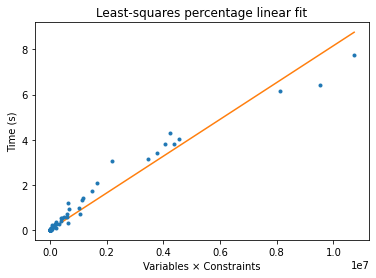

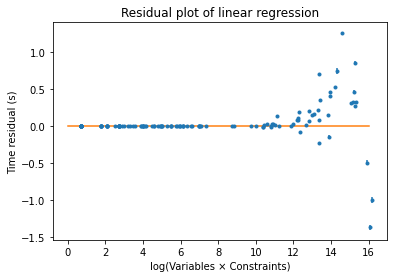

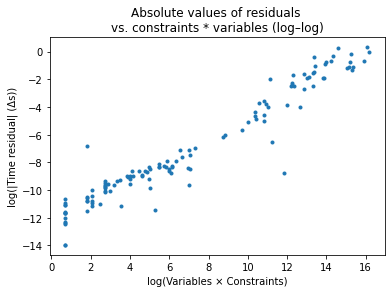

R² of log(|residuals|) to log(constraints * variables): 0.9306138661603162


In [6]:
### Plotting `solve` times against |constraints| × |variables|

times = np.array(solve_times)
uncs = np.array(solve_uncs)
constraints = np.array(solve_constraints)
variables = np.array(solve_variables)
vcs = variables * constraints
mean_time = np.mean(times)

# Least Squares Percentage Regression (https://doi.org/10.2139%2Fssrn.1406472)
# slope = (Σ(vcs/times)Σ(1/times²) - Σ(1/times)Σ(vcs/times²)) / (Σ(1/times²)Σ(vcs/times)² - (Σ(x/times²))²)
# intercept = (Σ(1/times) - slope * Σ(vcs/times²)) / Σ(1/times²)
# slope = (np.sum(vcs/times) * np.sum(1/np.power(times, 2)) - np.sum(1/times) * np.sum(vcs/np.power(times, 2))) / (np.sum(1/np.power(times, 2)) * np.sum(np.power(vcs/times, 2)) - np.power(np.sum(vcs/np.power(times, 2)), 2))
# intercept = (np.sum(1/times) - slope * np.sum(vcs/np.power(times, 2))) / np.sum(1/np.power(times, 2))

# Ordinary Least Squares Regression
[slope, intercept], cov = curve_fit(linear, vcs, times, sigma = uncs)
[[slope_var, _], [_, intercept_var]] = cov

def model(x):
    return linear(x, slope, intercept)
residuals = times - model(vcs)

# R² = (Σ((ŷ-ȳ)/y)²) / (Σ((y-ȳ)/y)²)
Rsq = np.sum([np.power((model(vc) - mean_time) / time, 2) for (vc, time) in zip(vcs, times)]) / np.sum([np.power((time - mean_time) / time, 2) for time in times])
chisq = np.power(residuals / uncs, 2).sum() / (len(vcs) - 2)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"r: {pearsonr(vcs, times)[0]}; R²: {Rsq}")
print(f"Reduced χ²: {chisq}")

vcs_space = np.linspace(0, max(vcs), 128)
plt.errorbar(vcs, times, yerr = uncs, fmt = ".")
plt.plot(vcs_space, model(vcs_space), "-")
plt.title("Least-squares percentage linear fit")
plt.xlabel("Variables × Constraints")
plt.ylabel("Time (s)")
plt.show()

_vcs = [vc for vc in vcs if vc > 0]
_times = [t for (t, vc) in zip(times, vcs) if vc > 0]
_residuals = [r for (r, vc) in zip(residuals, vcs) if vc > 0]
_uncs = [u for (u, vc) in zip(uncs, vcs) if vc > 0]
_vcs_space = np.linspace(0, round(max(np.log(_vcs))), 128)

plt.errorbar(np.log(_vcs), _residuals, yerr = _uncs, fmt = ".")
plt.plot(_vcs_space, np.zeros(128), "-")
plt.title("Residual plot of linear regression")
plt.xlabel("log(Variables × Constraints)")
plt.ylabel("Time residual (s)")
plt.show()

# plt.errorbar(np.log(_vcs), np.divide(_residuals, _times), yerr = _uncs, fmt = ".")
# plt.plot(_vcs_space, np.zeros(128), "-")
# plt.title("Relative residual plot of linear regression")
# plt.xlabel("log(Variables × Constraints)")
# plt.ylabel("Relative time residual")
# plt.show()

plt.plot(np.log(_vcs), np.log(np.abs(_residuals)), ".")
plt.title("Absolute values of residuals \nvs. constraints * variables (log–log)")
plt.xlabel("log(Variables × Constraints)")
plt.ylabel("log(|Time residual| (Δs))")
plt.show()

print(f"R² of log(|residuals|) to log(constraints * variables): {np.power(pearsonr(np.log(_vcs), np.log(np.abs(_residuals)))[0], 2)}")

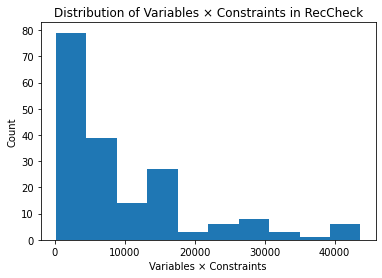

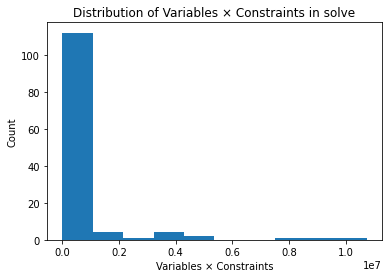

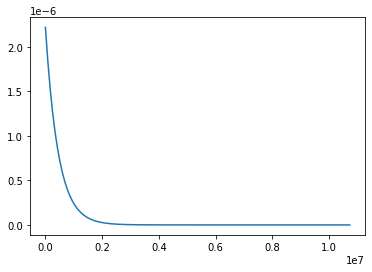

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000000] [loc=450204.832 scale=1521565.707]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000000] [loc=0.000 scale=450204.832]
[distfit] >[pareto    ] [0.04 sec] [RSS: 0.0000000] [loc=-2.455 scale=2.455]
[distfit] >[dweibull  ] [0.06 sec] [RSS: 0.0000000] [loc=-0.000 scale=939262.371]
[distfit] >[t         ] [0.01 sec] [RSS: 0.0000000] [loc=0.001 scale=0.003]
[distfit] >[genextreme] [0.23 sec] [RSS: 0.0000000] [loc=3.275 scale=19.031]
[distfit] >[gamma     ] [0.14 sec] [RSS: 0.0000000] [loc=-0.000 scale=4450383.102]
[distfit] >[lognorm   ] [0.15 sec] [RSS: 0.0000000] [loc=-0.000 scale=11167.949]
[distfit] >[beta      ] [0.11 sec] [RSS: 0.0000000] [loc=-0.000 scale=122434363.605]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000000] [loc=0.000 scale=10732600.000]
[distfit] >[loggamma  ] [0.06 sec] [RSS: 0.0000000] [loc=-544748297.810 scale=71337300.490]
[distfit] >Compute confidence interval [parametric]
[dis

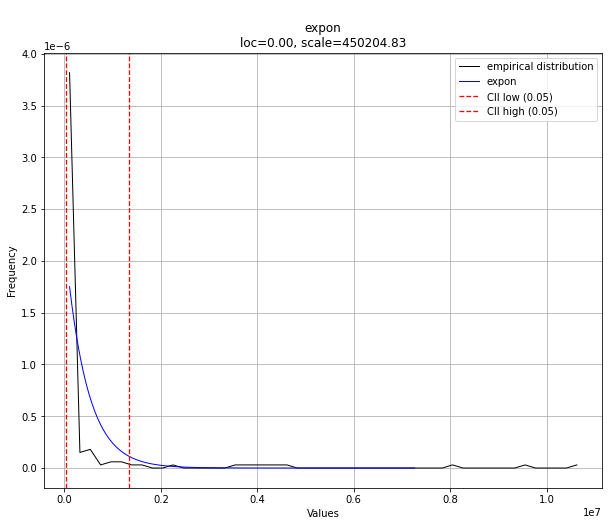

         distr score  LLE               loc             scale  \
0        expon   0.0  NaN               0.0     450204.832258   
1         beta   0.0  NaN              -0.0  122434363.605099   
2        gamma   0.0  NaN              -0.0    4450383.102096   
3     dweibull   0.0  NaN              -0.0     939262.371317   
4      lognorm   0.0  NaN              -0.0      11167.949461   
5   genextreme   0.0  NaN          3.275198         19.031003   
6       pareto   0.0  NaN         -2.454546          2.454545   
7         norm   0.0  NaN     450204.832258    1521565.707066   
8     loggamma   0.0  NaN -544748297.810221   71337300.489894   
9            t   0.0  NaN          0.000977          0.002857   
10     uniform   0.0  NaN               0.0        10732600.0   

                                         arg  
0                                         ()  
1   (0.19439890446153743, 515.4151704091594)  
2                     (0.27644692104732826,)  
3                      (0.66171

In [7]:
from distfit import distfit
from scipy.stats import pareto, expon

reccheck_vc = np.array(reccheck_variables) * np.array(reccheck_constraints)
plt.hist([vc for vc in reccheck_vc if vc > 0], 10)
plt.title("Distribution of Variables × Constraints in RecCheck")
plt.xlabel("Variables × Constraints")
plt.ylabel("Count")
plt.show()

solve_vc = np.array(solve_variables) * np.array(solve_constraints)
plt.hist([vc for vc in solve_vc if vc > 0], 10)
plt.title("Distribution of Variables × Constraints in solve")
plt.xlabel("Variables × Constraints")
plt.ylabel("Count")
plt.show()

loc, scale = expon.fit(vcs)
x = np.linspace(0, max(vcs), 128)
plt.plot(x, expon.pdf(x, loc, scale))
plt.show()

# https://erdogant.github.io/distfit/pages/html/Performance.html#probability-density-function-fitting
dist = distfit()
dist.fit_transform(vcs)
dist.plot()
print(dist.summary)
print(dist.model)

R²: 0.9925630398466596
Slope: 1.149150214492404
Intercept: -0.5162065891937406
Reduced χ²: 0.09341027048211409


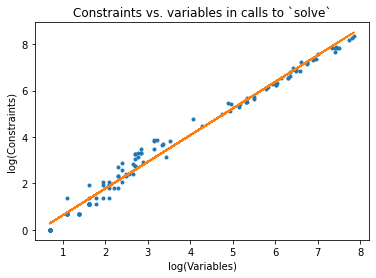

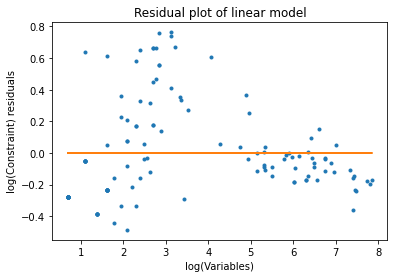

In [8]:
# Plotting constraints against variables

_variables = [v for (v, c) in zip(variables, constraints) if v > 0 and c > 0]
_constraints = [c for (v, c) in zip(variables, constraints) if v > 0 and c > 0]

[slope, intercept], _ = curve_fit(linear, np.log(_variables), np.log(_constraints))

def vcmodel(x):
    return linear(x, slope, intercept)
residuals = np.log(_constraints) - vcmodel(np.log(_variables))
chisq = np.power(residuals, 2).sum() / (len(_variables) - 2)

print("R²: {0}".format(np.power(pearsonr(variables, constraints)[0], 2)))
print("Slope: {0}".format(slope))
print("Intercept: {0}".format(intercept))
print("Reduced χ²: {0}".format(chisq))

plt.plot(np.log(_variables), np.log(_constraints), ".", np.log(_variables), vcmodel(np.log(_variables)))
plt.title("Constraints vs. variables in calls to `solve`")
plt.xlabel("log(Variables)")
plt.ylabel("log(Constraints)")
plt.show()

plt.plot(np.log(_variables), residuals, ".", np.log(_variables), np.zeros(len(_variables)), "-")
plt.title("Residual plot of linear model")
plt.xlabel("log(Variables)")
plt.ylabel("log(Constraint) residuals")
plt.show()